In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, BertModel
import torch, torch.nn as nn, torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np, os
from PIL import Image
from tqdm import tqdm
import soundfile as sf
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


## 1. 오디오 임베딩 추출

In [15]:
MODEL_PATH = "E:/PD_Voice_Wav2Vec2_project/model/wav2vec2/wav2vec2-finetuned-pd-preprocess-weightdecay/checkpoint-1690"
processor = Wav2Vec2Processor.from_pretrained(MODEL_PATH)
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
audio_model.eval()

def load_audio_dataset(root):
    paths, labels = [], []
    for label_name in ["healthy", "parkinson"]:
        label = 0 if label_name == "healthy" else 1
        folder = os.path.join(root, label_name)
        for f in os.listdir(folder):
            if f.lower().endswith((".wav", ".flac")):
                paths.append(os.path.join(folder, f))
                labels.append(label)
    return paths, labels

def extract_audio_embeddings(file_list, labels):
    feats, y = [], []
    for path, label in tqdm(zip(file_list, labels), total=len(file_list), desc="Audio Embedding"):
        audio, _ = sf.read(path)
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        with torch.no_grad():
            out = audio_model(**inputs, output_hidden_states=True)
            pooled = torch.mean(out.hidden_states[-1], dim=1).squeeze().cpu().numpy()
        feats.append(pooled)
        y.append(label)
    return np.array(feats), np.array(y)


## 2. 이미지 임베딩 추출

In [16]:
cnn_model = models.resnet18(pretrained=True)
cnn_model.fc = nn.Identity()
cnn_model.eval().to(DEVICE)

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def load_mfcc_image_dataset(root):
    paths, labels = [], []
    for label_name in ["healthy", "parkinson"]:
        label = 0 if label_name == "healthy" else 1
        folder = os.path.join(root, label_name)
        for f in os.listdir(folder):
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                paths.append(os.path.join(folder, f))
                labels.append(label)
    return paths, labels

def extract_mfcc_embeddings(img_paths, labels):
    feats, y = [], []
    for path, label in tqdm(zip(img_paths, labels), total=len(img_paths), desc="Image Embedding"):
        img = Image.open(path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            feat = cnn_model(img).squeeze().cpu().numpy()
        feats.append(feat)
        y.append(label)
    return np.array(feats), np.array(y)


c:\Users\qkrgu\anaconda3\envs\wav2vec2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\qkrgu\anaconda3\envs\wav2vec2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Cross-Attention + LLM 분류기

In [17]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, audio_dim=768, img_dim=512, hidden_dim=512, num_heads=8):
        super().__init__()
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, audio_feat, img_feat):
        q = self.audio_proj(audio_feat).unsqueeze(1)
        k = self.img_proj(img_feat).unsqueeze(1)
        v = k
        out, _ = self.cross_attn(q, k, v)
        return self.fc(self.norm(out + q)).squeeze(1)

class MultiModalClassifier(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        self.fusion = CrossAttentionFusion(hidden_dim=hidden_dim)
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc_in = nn.Linear(hidden_dim, 768)
        self.fc_out = nn.Linear(768, 2)

    def forward(self, audio_feat, img_feat):
        fused = self.fusion(audio_feat, img_feat)
        x = self.fc_in(fused).unsqueeze(1)
        outputs = self.bert(inputs_embeds=x)
        return self.fc_out(outputs.pooler_output)


In [19]:
def train_model(model, train_loader, test_loader, save_path, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    best_auc = 0.0

    for epoch in range(epochs):
        model.train()
        train_losses, train_accs = [], []
        for audio_batch, img_batch, y_batch in train_loader:
            audio_batch, img_batch, y_batch = audio_batch.to(DEVICE), img_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = model(audio_batch, img_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            acc = accuracy_score(y_batch.cpu(), preds.cpu())
            train_losses.append(loss.item())
            train_accs.append(acc)

        # Validation
        model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for audio_batch, img_batch, y_batch in test_loader:
                audio_batch, img_batch = audio_batch.to(DEVICE), img_batch.to(DEVICE)
                logits = model(audio_batch, img_batch)
                probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probs)
                all_labels.extend(y_batch.numpy())

        auc = roc_auc_score(all_labels, all_probs)
        print(f"Epoch {epoch+1}/{epochs} | TrainLoss {np.mean(train_losses):.4f} | TrainAcc {np.mean(train_accs):.4f} | ValAUC {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), save_path)
            print(f" Best model saved (AUC={best_auc:.4f})")
    return best_auc

In [20]:
def evaluate_model(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for audio_batch, img_batch, y_batch in loader:
            audio_batch, img_batch = audio_batch.to(DEVICE), img_batch.to(DEVICE)
            logits = model(audio_batch, img_batch)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(y_batch.numpy())

    preds = (np.array(all_probs) > 0.5).astype(int)
    auc_val = roc_auc_score(all_labels, all_probs)
    acc_val = accuracy_score(all_labels, preds)
    print(f"\nAUC: {auc_val:.4f} | Accuracy: {acc_val:.4f}")
    print(classification_report(all_labels, preds, target_names=["Healthy", "Parkinson"], digits=4))

    # 시각화
    ConfusionMatrixDisplay(confusion_matrix(all_labels, preds),
                           display_labels=["Healthy", "Parkinson"]).plot(cmap="Blues")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.4f}")
    plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve"); plt.show()


## 4. 실행 파이프라인

Epoch 1/10 | TrainLoss 0.3400 | TrainAcc 0.8989 | ValAUC 0.9619
 Best model saved (AUC=0.9619)
Epoch 2/10 | TrainLoss 0.2963 | TrainAcc 0.9154 | ValAUC 0.9316
Epoch 3/10 | TrainLoss 0.2960 | TrainAcc 0.9154 | ValAUC 0.9305
Epoch 4/10 | TrainLoss 0.2967 | TrainAcc 0.9136 | ValAUC 0.8208
Epoch 5/10 | TrainLoss 0.2930 | TrainAcc 0.9154 | ValAUC 0.8532
Epoch 6/10 | TrainLoss 0.2938 | TrainAcc 0.9154 | ValAUC 0.8235
Epoch 7/10 | TrainLoss 0.3072 | TrainAcc 0.9118 | ValAUC 0.9455
Epoch 8/10 | TrainLoss 0.2933 | TrainAcc 0.9154 | ValAUC 0.8737
Epoch 9/10 | TrainLoss 0.2882 | TrainAcc 0.9173 | ValAUC 0.8874
Epoch 10/10 | TrainLoss 0.2927 | TrainAcc 0.9154 | ValAUC 0.8758


Image Embedding: 100%|██████████| 200/200 [00:01<00:00, 170.64it/s]
C:\Users\qkrgu\AppData\Local\Temp\ipykernel_17844\2612486941.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe


AUC: 0.9593 | Accuracy: 0.9250
              precision    recall  f1-score   support

     Healthy     0.9885    0.8600    0.9198       100
   Parkinson     0.8761    0.9900    0.9296       100

    accuracy                         0.9250       200
   macro avg     0.9323    0.9250    0.9247       200
weighted avg     0.9323    0.9250    0.9247       200



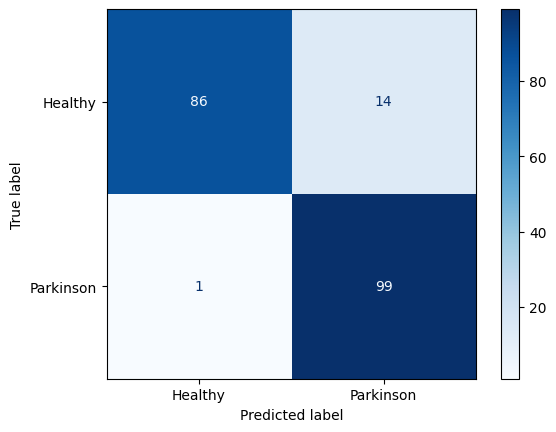

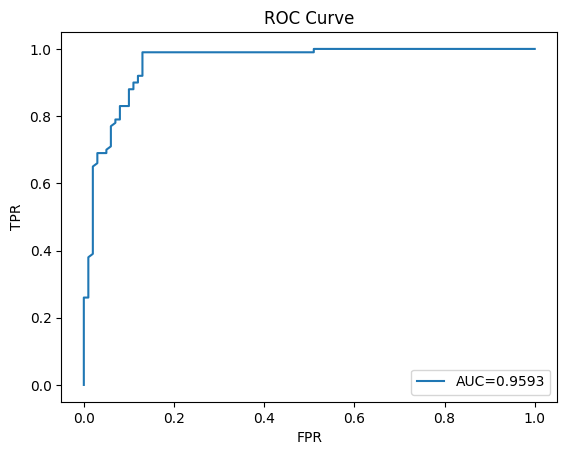

In [21]:
# ========== 1. 임베딩 로드 ==========
X_audio = np.load("wav2vec_features.npy")
X_img = np.load("mfcc_features.npy")
y = np.load("wav2vec_labels.npy")

# ========== 2. 데이터 분할 ==========
Xa_tr, Xa_te, Xi_tr, Xi_te, y_tr, y_te = train_test_split(X_audio, X_img, y, test_size=0.2, random_state=42, stratify=y)

train_loader = DataLoader(TensorDataset(torch.tensor(Xa_tr, dtype=torch.float32),
                                        torch.tensor(Xi_tr, dtype=torch.float32),
                                        torch.tensor(y_tr, dtype=torch.long)),
                          batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(Xa_te, dtype=torch.float32),
                                       torch.tensor(Xi_te, dtype=torch.float32),
                                       torch.tensor(y_te, dtype=torch.long)),
                         batch_size=8, shuffle=False)

# ========== 3. 모델 학습 ==========
SAVE_PATH = "E:/PD_Voice_Wav2Vec2_project/model/best_multimodal_model.pth"
model = MultiModalClassifier().to(DEVICE)
best_auc = train_model(model, train_loader, test_loader, SAVE_PATH, epochs=10)

# ========== 4. 외부 데이터 평가 ==========
ext_audio_root = "E:/PD_Voice_Wav2Vec2_project/data/italian_voice_pdhc_split"
ext_img_root = "E:/PD_Voice_Wav2Vec2_project/data/italian_voice_pdhc_split_img"
ext_audio_paths, ext_audio_labels = load_audio_dataset(ext_audio_root)
ext_img_paths, ext_img_labels = load_mfcc_image_dataset(ext_img_root)

X_audio_ext, y_audio_ext = extract_audio_embeddings(ext_audio_paths, ext_audio_labels)
X_img_ext, y_img_ext = extract_mfcc_embeddings(ext_img_paths, ext_img_labels)

assert np.array_equal(y_audio_ext, y_img_ext)
ext_loader = DataLoader(TensorDataset(torch.tensor(X_audio_ext, dtype=torch.float32),
                                      torch.tensor(X_img_ext, dtype=torch.float32),
                                      torch.tensor(y_audio_ext, dtype=torch.long)),
                        batch_size=8, shuffle=False)

model.load_state_dict(torch.load(SAVE_PATH))
evaluate_model(model, ext_loader)
